In [1]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from functools import lru_cache
import pandas as pd
import numpy as np
import torch
from torch.optim import AdamW
from gluonts.time_feature import get_lags_for_frequency
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction, PretrainedConfig
from gluonts.time_feature import time_features_from_frequency_str, TimeFeature, get_seasonality
from gluonts.dataset.field_names import FieldName
from gluonts.transform import AddAgeFeature, AddObservedValuesIndicator, AddTimeFeatures, Chain, ExpectedNumInstanceSampler, InstanceSplitter, RemoveFields, SetField, TestSplitSampler, Transformation, VstackFeatures, RenameFields, AsNumpyArray, InstanceSampler, ValidationSplitSampler
from gluonts.itertools import Cached, Cyclic
from gluonts.dataset.loader import as_stacked_batches
from typing import Optional, Iterable
from accelerate import Accelerator
from evaluate import load
from functools import partial
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.common import ListDataset

/home/felix/anaconda3/envs/test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Disclaimer:** This [tutorial](https://huggingface.co/blog/time-series-transformers) served as a template 

In [2]:
# Path to dataset
metadata = 'data/metadata_sanitized.csv'
dataset = 'data/dataset_small.csv'

In [3]:
# load data
metadata = pd.read_csv(metadata)
dataset = pd.read_csv(dataset)

# Bring the data into right shape for further processing

In [4]:
# split meter data into train and test set. Train data is year 2016, test data is the first week of 2017
dataset_train = dataset[dataset['timestamp'].apply(lambda x: x.split('-')[0]) == '2016']
dataset_test = dataset[dataset['timestamp'].apply(lambda x: x.split('-')[0]) == '2017']

# get only first week of 2017 7*24=168 rows per building_id
dataset_test = dataset_test.groupby('building_id').head(7*24)
dataset_test

,timestamp,building_id,meter_reading,site_id,airTemperature,dewTemperature,seaLvlPressure,windDirection,windSpeed
8784,2017-01-01 00:00:00,Fox_public_Bart,43.920,Fox,13.3,11.7,1009.8,90.0,3.1
8785,2017-01-01 01:00:00,Fox_public_Bart,44.890,Fox,13.3,11.1,1008.8,120.0,3.6
8786,2017-01-01 02:00:00,Fox_public_Bart,45.920,Fox,13.3,11.7,1008.0,100.0,3.6
8787,2017-01-01 03:00:00,Fox_public_Bart,44.250,Fox,12.8,11.7,1007.4,90.0,2.6
8788,2017-01-01 04:00:00,Fox_public_Bart,41.970,Fox,12.8,11.7,1006.7,120.0,3.6
...,...,...,...,...,...,...,...,...,...
166843,2017-01-07 19:00:00,Cockatoo_lodging_Javier,55.550,Cockatoo,-8.9,-13.9,1024.9,300.0,4.6
166844,2017-01-07 20:00:00,Cockatoo_lodging_Javier,54.525,Cockatoo,-9.4,-13.9,1024.4,300.0,6.7
166845,2017-01-07 21:00:00,Cockatoo_lodging_Javier,55.100,Cockatoo,-10.0,-14.4,1024.3,310.0,3.6
166846,2017-01-07 22:00:00,Cockatoo_lodging_Javier,53.600,Cockatoo,-10.6,-14.4,1024.2,300.0,5.1


In [5]:
# convert meter data to dictionary where 'start' is the timestamp, 'target' is the meter_reading and 'feat_dynamic_real' is the airTemperature, dewTemperature, windDirection and windSpeed
train_dict = dataset_train.groupby('building_id').apply(lambda x: {'start': x['timestamp'].values[0],
                                                                   'target': x['meter_reading'].values,
                                                                   'feat_dynamic_real': x[['airTemperature', 'dewTemperature', 'windDirection', 'windSpeed']].values}).to_dict()
train_dict

{'Bear_education_Gavin': {'start': '2016-01-01 00:00:00',
  'target': array([74.4188, 77.8313, 72.5125, ..., 83.0575, 78.1415, 85.9358]),
  'feat_dynamic_real': array([[  4.4,  -2.2,   0. ,   0. ],
         [  4.4,  -4.4,  20. ,   2.1],
         [  4.4,  -6.7,  20. ,   2.1],
         ...,
         [  8.9,   5. , 250. ,   2.1],
         [  6.1,   4.4,   0. ,   0. ],
         [  8.3,   6.1, 120. ,   3.1]])},
 'Bull_education_Shona': {'start': '2016-01-01 00:00:00',
  'target': array([  0., 183., 183., ..., 185., 185., 186.]),
  'feat_dynamic_real': array([[  9.4,   3.3,  20. ,   4.1],
         [  8.9,   2.2,  30. ,   3.1],
         [  8.9,   2.2,  20. ,   3.1],
         ...,
         [ 18.3,  15. , 140. ,   1.5],
         [ 17.2,  15. ,   0. ,   0. ],
         [ 16.1,  14.4,   0. ,   0. ]])},
 'Cockatoo_assembly_Mimi': {'start': '2016-01-01 00:00:00',
  'target': array([0., 0., 0., ..., 0., 0., 0.]),
  'feat_dynamic_real': array([[-13.25  , -15.425 , 302.5   ,   6.1875],
         [-11.5 

In [6]:
# create a mapping for primaryspaceusage and sub_primaryspaceusage to integers
primaryspaceusage_mapping = {value: key for key, value in enumerate(metadata['primaryspaceusage'].unique())}
sub_primaryspaceusage_mapping = {value: key for key, value in enumerate(metadata['sub_primaryspaceusage'].unique())}

In [7]:
for key in train_dict.keys():
    # add metadata (sqm, primaryspaceusage, sub_primaryspaceusage, lat, lng) to train_dict as static data
    train_dict[key]['feat_static_cat'] = metadata[metadata['building_id'] == key][['primaryspaceusage', 'sub_primaryspaceusage']].values[0]

    # add buildung_id as item_id
    train_dict[key]['item_id'] = key  

    # convert 'primaryspaceusage' and 'sub_primaryspaceusage' to mapped integers
    train_dict[key]['feat_static_cat'][0] = primaryspaceusage_mapping[train_dict[key]['feat_static_cat'][0]]
    train_dict[key]['feat_static_cat'][1] = sub_primaryspaceusage_mapping[train_dict[key]['feat_static_cat'][1]]
    
# convert train_dict to datasets.arrow_dataset.Dataset
train_ds = ListDataset(list(train_dict.values()), freq='H')
train_ds

[{'start': Period('2016-01-01 00:00', 'H'),
  'target': array([74.4188, 77.8313, 72.5125, ..., 83.0575, 78.1415, 85.9358],
        dtype=float32),
  'feat_dynamic_real': array([[  4.4,  -2.2,   0. ,   0. ],
         [  4.4,  -4.4,  20. ,   2.1],
         [  4.4,  -6.7,  20. ,   2.1],
         ...,
         [  8.9,   5. , 250. ,   2.1],
         [  6.1,   4.4,   0. ,   0. ],
         [  8.3,   6.1, 120. ,   3.1]], dtype=float32),
  'feat_static_cat': array([ 1, 48], dtype=int32),
  'item_id': 'Bear_education_Gavin'},
 {'start': Period('2016-01-01 00:00', 'H'),
  'target': array([  0., 183., 183., ..., 185., 185., 186.], dtype=float32),
  'feat_dynamic_real': array([[  9.4,   3.3,  20. ,   4.1],
         [  8.9,   2.2,  30. ,   3.1],
         [  8.9,   2.2,  20. ,   3.1],
         ...,
         [ 18.3,  15. , 140. ,   1.5],
         [ 17.2,  15. ,   0. ,   0. ],
         [ 16.1,  14.4,   0. ,   0. ]], dtype=float32),
  'feat_static_cat': array([ 1, 10], dtype=int32),
  'item_id': 'Bull_e

In [8]:
# same procedure for test data
# do the same for test data
test_dict = dataset_test.groupby('building_id').apply(lambda x: {'start': x['timestamp'].values[0],
                                                                 'target': x['meter_reading'].values,
                                                                 'feat_dynamic_real': x[['airTemperature', 'dewTemperature', 'windDirection', 'windSpeed']].values}).to_dict()
for key in test_dict.keys():
    test_dict[key]['feat_static_cat'] = metadata[metadata['building_id'] == key][['primaryspaceusage', 'sub_primaryspaceusage']].values[0]
    test_dict[key]['item_id'] = key
    test_dict[key]['feat_static_cat'][0] = primaryspaceusage_mapping[test_dict[key]['feat_static_cat'][0]]
    test_dict[key]['feat_static_cat'][1] = sub_primaryspaceusage_mapping[test_dict[key]['feat_static_cat'][1]]

test_ds = ListDataset(list(test_dict.values()), freq='H')
test_ds

[{'start': Period('2017-01-01 00:00', 'H'),
  'target': array([76.7488, 84.328 , 88.2395, 85.6002, 77.2525, 82.9755, 83.8452,
         75.7855, 84.2805, 80.9373, 80.3165, 84.076 , 82.2737, 79.0635,
         81.659 , 85.3922, 77.7475, 76.9477, 82.9258, 83.6908, 84.0402,
         82.6818, 78.5895, 84.576 , 80.5392, 80.568 , 84.423 , 82.7857,
         79.718 , 82.5225, 81.925 , 83.1822, 83.8728, 83.6095, 84.1295,
         81.8732, 82.4228, 84.4902, 84.9668, 83.239 , 80.1188, 82.7502,
         87.1557, 81.6005, 85.104 , 80.6597, 77.0012, 82.152 , 85.9655,
         80.6835, 83.0695, 85.6965, 77.8443, 83.7415, 84.6802, 82.6452,
         90.1887, 85.5875, 86.0468, 94.2607, 89.8525, 92.5902, 95.2607,
         99.1023, 89.635 , 84.3102, 86.1467, 87.2133, 84.5673, 83.8038,
         79.7272, 85.821 , 84.6702, 81.002 , 88.015 , 88.048 , 81.1403,
         80.7233, 86.1587, 84.3005, 86.988 , 86.0628, 85.8135, 94.0697,
         92.2302, 91.779 , 95.552 , 99.5665, 88.2797, 89.687 , 83.257 ,
         8

# Definition of the Model

In [9]:
freq = '1H'  # Define frequency of data
prediction_length = 7*24  # predict 7 days
lags_sequence = get_lags_for_frequency(freq)  # get lags for frequency from gluonts function
# the lags define how far back in time the model can look to make predictions. In this case the model looks back 721 hours (30 days) to make predictions
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7, 23, 24, 25, 47, 48, 49, 71, 72, 73, 95, 96, 97, 119, 120, 121, 143, 144, 145, 167, 168, 169, 335, 336, 337, 503, 504, 505, 671, 672, 673, 719, 720, 721]


In [10]:
# define the time features with gluonts function
time_features = time_features_from_frequency_str(freq)
# the model uses four time features: hour of day, day of week, day of month and month of year
print(time_features)

[<function hour_of_day at 0x7f2c7c769120>, <function day_of_week at 0x7f2c7c769240>, <function day_of_month at 0x7f2c7c769360>, <function day_of_year at 0x7f2c7c769480>]


In [11]:
# definition of time features
config = TimeSeriesTransformerConfig(
    prediction_length = prediction_length,  # forecast 7 days ahead
    context_length = 2 * prediction_length,  # predict twice as long as the context length
    lag_sequence = lags_sequence,  # use the lags defined above (loock back up to 721 hours)
    num_time_features = len(time_features) + 1,  # four time features plus one age feature
    num_static_categorical_features = 2,  # two static categorical features ('primaryspaceusage', 'sub_primaryspaceusage')
    cardinality = [len(primaryspaceusage_mapping), len(sub_primaryspaceusage_mapping)],  # The number of values each categorical feature can take
    embedding_dimension = [2, 2],  # model will learn embedding of 1 for each of the possible values for each categorical feature

    # parameters for transformer
    encoder_layers = 4,
    decoder_layer = 4, 
    d_model = 32,
)

model = TimeSeriesTransformerForPrediction(config)

In [12]:
# define the transformation of the data
def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    return Chain(
        # remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # convert to numpy
        + (
            [
                AsNumpyArray(
                    field = FieldName.FEAT_STATIC_CAT,
                    expected_ndim = 1,
                    dtype = int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field = FieldName.FEAT_STATIC_REAL,
                    expected_ndim = 1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field = FieldName.TARGET,
                # expect an extra dim for multivariate case
                expected_ndim = 1 if config.input_size == 1 else 2,
            ),
            # fill NaNs with zeros and return mask (true for observed values and false for NaNs),
            # the decoder uses this mask (no loss for NaN values)
            AddObservedValuesIndicator(
                target_field = FieldName.TARGET,
                output_field = FieldName.OBSERVED_VALUES,
            ),
            # add temporal features based on freq of the dataset
            # month of year in the case when freq='M' (serve as positional encodings)
            AddTimeFeatures(
                start_field = FieldName.START,
                target_field = FieldName.TARGET,
                output_field = FieldName.FEAT_TIME,
                time_features = time_features_from_frequency_str(freq),
                pred_length = config.prediction_length,
            ),
            # add another temporal feature (single number), tells the model where in its life the value of the time series is (sort of a running counter)
            AddAgeFeature(
                target_field = FieldName.TARGET,
                output_field = FieldName.FEAT_AGE,
                pred_length = config.prediction_length,
                log_scale = True,
            ),
            # vertically stack all temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field = FieldName.FEAT_TIME,
                input_fields = [FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # rename to match HuggingFace names
            RenameFields(
                mapping = {
                    FieldName.FEAT_STATIC_CAT: 'static_categorical_features',
                    FieldName.FEAT_STATIC_REAL: 'static_real_features',
                    FieldName.FEAT_TIME: 'time_features',
                    FieldName.TARGET: 'values',
                    FieldName.OBSERVED_VALUES: 'observed_mask',
                }
            ),
        ]
    )

In [13]:
# create Instance Splitter to sample windows from dataset
def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ['train', 'validation', 'test']

    instance_sampler = {
        'train': train_sampler or ExpectedNumInstanceSampler(num_instances = 1.0, min_future = config.prediction_length),
        'validation': validation_sampler or ValidationSplitSampler(min_future = config.context_length + config.prediction_length),
        'test': TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field = 'values',
        is_pad_field = FieldName.IS_PAD,
        start_field = FieldName.START,
        forecast_start_field = FieldName.FORECAST_START,
        instance_sampler = instance_sampler,
        past_length = config.context_length + max(config.lags_sequence),
        future_length = config.prediction_length,
        time_series_fields = ['time_features', 'observed_mask'],
    )

In [14]:
# create DataLoaders to have batches (input, output) pairs
def create_train_dataloader(
    config: PretrainedConfig,
    freq: str,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        'past_time_features',
        'past_values',
        'past_observed_mask',
        'future_time_features',
    ]

    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append('static_categorical_features')

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append('static_real_features')

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + ['future_values', 'future_observed_mask']

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train = True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # init training instance
    instance_splitter = create_instance_splitter(config, 'train')

    # instance splitter will sample window of context_length + lags + prediction_length (from 366 possible transformed time series)
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(stream, is_train = True)

    return as_stacked_batches(
        training_instances,
        batch_size = batch_size,
        shuffle_buffer_length = shuffle_buffer_length,
        field_names = TRAINING_INPUT_NAMES,
        output_type = torch.tensor,
        num_batches_per_epoch = num_batches_per_epoch,
    )
    

def create_test_dataloader(
    config: PretrainedConfig,
    freq: str,
    data,
    batch_size: int,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        'past_time_features',
        'past_values',
        'past_observed_mask',
        'future_time_features',
    ]

    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append('static_categorical_features')

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append('static_real_features')

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train = False)

    # create test instance splitter, context window seen during training only for encoder
    instance_splitter = create_instance_splitter(config, 'test')

    # apply transformations in test mode
    testing_instances = instance_splitter.apply(transformed_data, is_train = False)

    return as_stacked_batches(
        testing_instances,
        batch_size = batch_size,
        output_type = torch.tensor,
        field_names = PREDICTION_INPUT_NAMES,
    )

In [15]:
train_dataloader = create_train_dataloader(
    config = config,
    freq = freq,
    data = train_ds,
    batch_size = 8,
    num_batches_per_epoch = 4,
)

test_dataloader = create_test_dataloader(
    config = config,
    freq = freq,
    data = test_ds,
    batch_size = 4,
)

In [16]:
# check first batch 
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([8, 343, 5]) torch.FloatTensor
past_values torch.Size([8, 343]) torch.FloatTensor
past_observed_mask torch.Size([8, 343]) torch.FloatTensor
future_time_features torch.Size([8, 168, 5]) torch.FloatTensor
static_categorical_features torch.Size([8, 2]) torch.LongTensor
future_values torch.Size([8, 168]) torch.FloatTensor
future_observed_mask torch.Size([8, 168]) torch.FloatTensor


In [17]:
# forward pass
outputs = model(
    past_values = batch['past_values'],
    past_time_features = batch['past_time_features'],
    past_observed_mask = batch['past_observed_mask'],
    static_categorical_features = batch['static_categorical_features'] if config.num_static_categorical_features > 0 else None,
    static_real_features = batch['static_real_features'] if config.num_static_real_features > 0 else None,
    future_values = batch['future_values'],
    future_time_features = batch['future_time_features'],
    future_observed_mask = batch['future_observed_mask'],
    output_hidden_states = True,
)

In [18]:
accelerator = Accelerator()
device = accelerator.device
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 6e-4, betas = (0.9, 0.95), weight_decay = 1e-1)
model, optimizer, train_dataloader = accelerator.prepare(model, optimizer, train_dataloader)
print(f'Using device: {device}')

Using device: cuda


In [19]:
# train the model

model.train()
for epoch in range(5_000):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features = batch['static_categorical_features'].to(device) if config.num_static_categorical_features > 0 else None,
            static_real_features = batch['static_real_features'].to(device) if config.num_static_real_features > 0 else None,
            past_time_features = batch['past_time_features'].to(device),
            past_values = batch['past_values'].to(device),
            future_time_features = batch['future_time_features'].to(device),
            future_values = batch['future_values'].to(device),
            past_observed_mask = batch['past_observed_mask'].to(device),
            future_observed_mask = batch['future_observed_mask'].to(device),
        )
        loss = outputs.loss

        accelerator.backward(loss)
        optimizer.step()

        if idx % 100 == 0:
            print(f'Epoch: {epoch}, Batch: {idx}, Loss: {loss}')

Epoch: 0, Batch: 0, Loss: -1.517745018005371
Epoch: 1, Batch: 0, Loss: 6.781331539154053
Epoch: 2, Batch: 0, Loss: 6.353196620941162
Epoch: 3, Batch: 0, Loss: 5.279430389404297
Epoch: 4, Batch: 0, Loss: 3.0315754413604736
Epoch: 5, Batch: 0, Loss: 5.242589473724365
Epoch: 6, Batch: 0, Loss: 4.59633731842041
Epoch: 7, Batch: 0, Loss: 3.578176498413086
Epoch: 8, Batch: 0, Loss: 4.904954433441162
Epoch: 9, Batch: 0, Loss: 4.708608150482178
Epoch: 10, Batch: 0, Loss: 6.537868022918701
Epoch: 11, Batch: 0, Loss: 4.649411201477051
Epoch: 12, Batch: 0, Loss: 1.162999153137207
Epoch: 13, Batch: 0, Loss: 5.331140995025635
Epoch: 14, Batch: 0, Loss: 4.908265590667725
Epoch: 15, Batch: 0, Loss: 5.589913368225098
Epoch: 16, Batch: 0, Loss: 4.283362865447998
Epoch: 17, Batch: 0, Loss: 2.2198097705841064
Epoch: 18, Batch: 0, Loss: 4.531856536865234
Epoch: 19, Batch: 0, Loss: 5.690582275390625
Epoch: 20, Batch: 0, Loss: 1.720862627029419
Epoch: 21, Batch: 0, Loss: 4.088621139526367
Epoch: 22, Batch: 

In [20]:
# Inference

model.eval()
forecasts = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features = batch['static_categorical_features'].to(device) if config.num_static_categorical_features > 0 else None,
        static_real_features = batch['static_real_features'].to(device) if config.num_static_real_features > 0 else None,
        past_time_features = batch['past_time_features'].to(device),
        past_values = batch['past_values'].to(device),
        future_time_features = batch['future_time_features'].to(device),
        past_observed_mask = batch['past_observed_mask'].to(device),
    )
    forecasts.append(outputs.sequences.cpu().numpy())

In [21]:
forecasts[0].shape  # 100 possible values for the next 168 hours for each of the 4 batchs

(4, 100, 168)

In [22]:
forecasts = np.vstack(forecasts)  # stack the forecasts for each batch together

In [23]:
# plot the results
def plot(ts_index):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start = test_ds[ts_index][FieldName.START],
        periods = len(test_ds[ts_index][FieldName.TARGET]),
        freq = freq,
    ).to_timestamp()

    # x_ticks every day
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    

    ax.plot(
        index[-2 * prediction_length:],
        test_ds[ts_index]['target'][-2 * prediction_length:],
        label = 'GT',
    )

    plt.plot(
        index[-prediction_length:],
        np.median(forecasts[ts_index], axis = 0),
        label = 'Forecast median',
    )

    plt.fill_between(
        index[-prediction_length:],
        forecasts[ts_index].mean(0) - forecasts[ts_index].std(axis = 0),
        forecasts[ts_index].mean(0) + forecasts[ts_index].std(axis = 0),
        alpha = 0.3,
        interpolate = True,
        label = 'Forecast 1 std',
    )

    plt.legend()
    plt.show()

# Plot some results

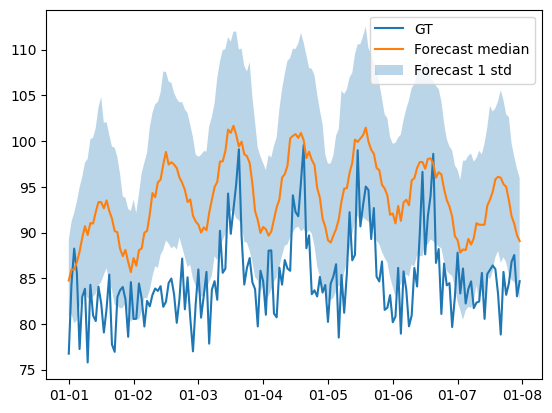

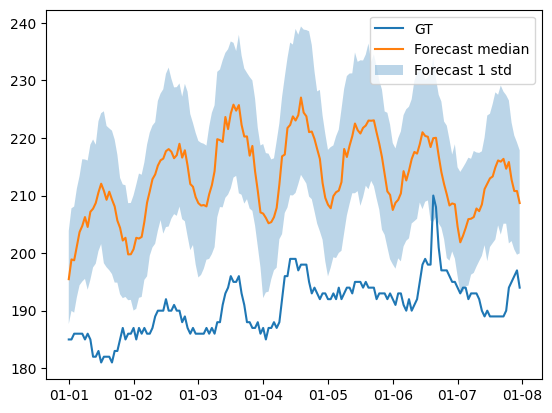

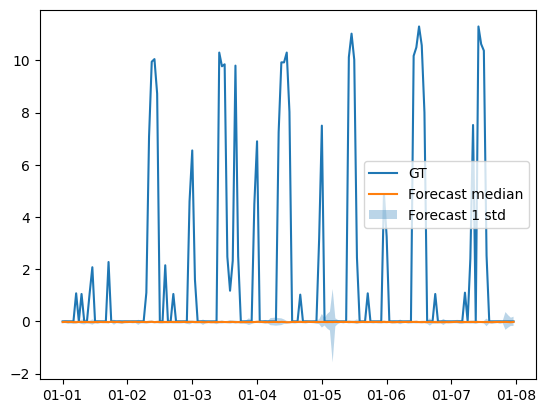

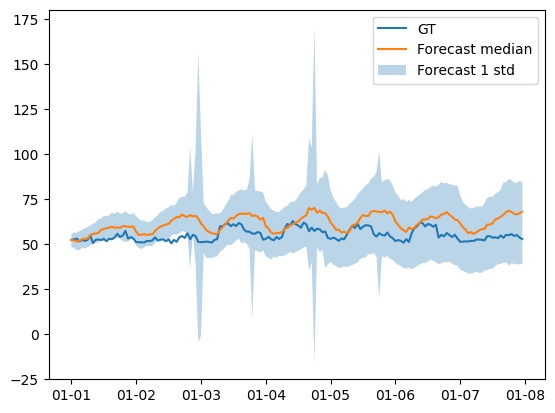

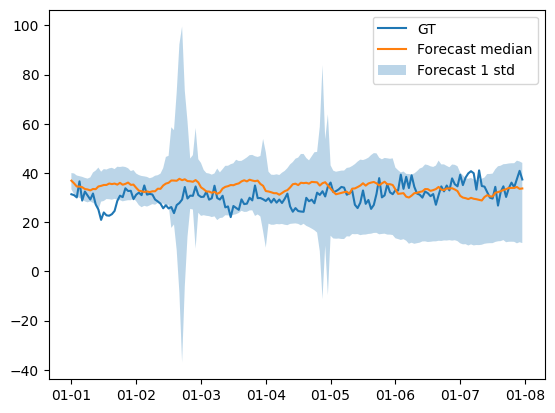

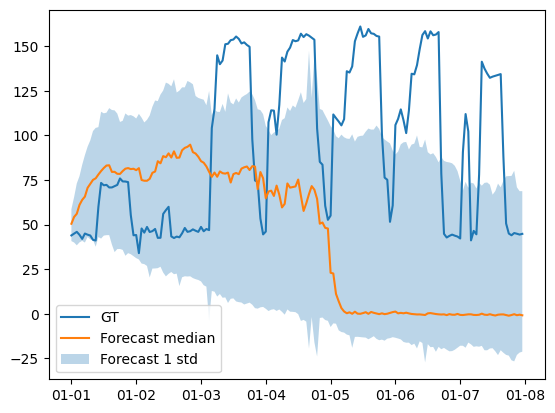

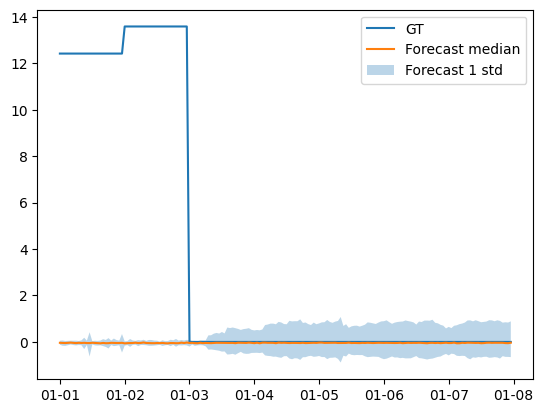

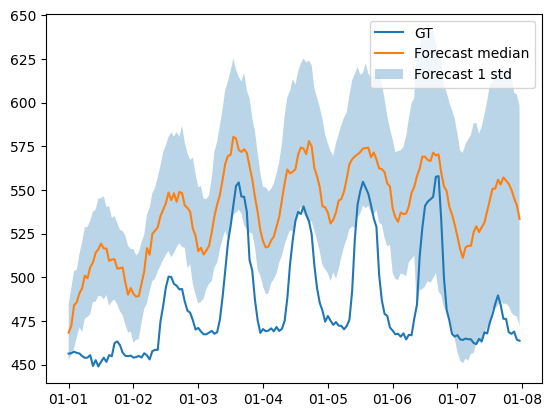

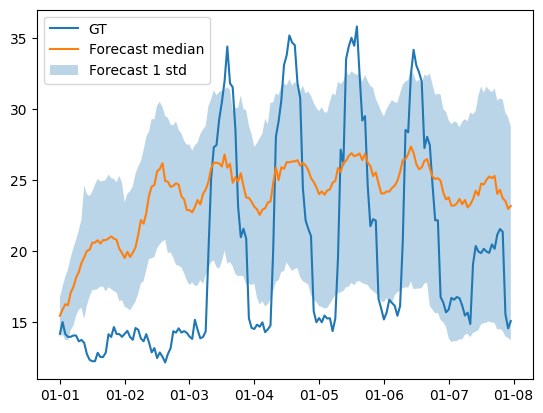

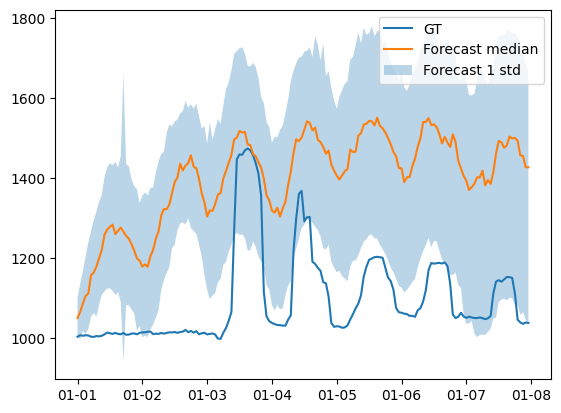

In [24]:
# plot 10 results in a loop
for i in range(10):
    plot(i)